In [15]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path=Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True,exist_ok=True)
        url="http://github.com//ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing=load_housing_data()

# housing.head()
# housing.info()
# housing["ocean_proximity"].value_counts()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


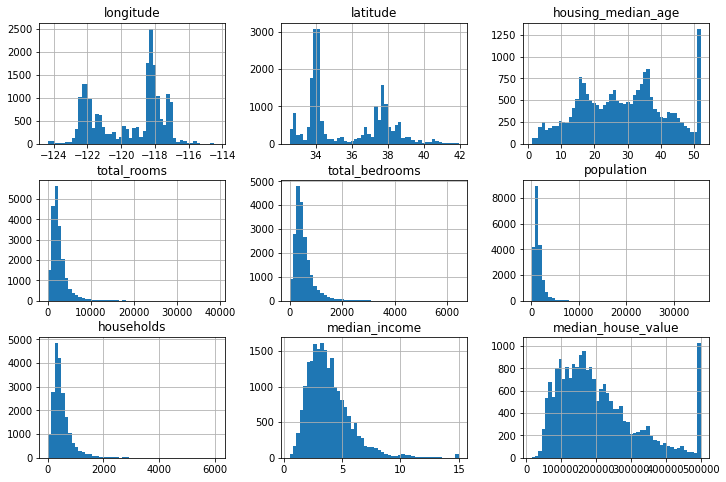

In [16]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [17]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set=shuffle_and_split_data(housing,0.2)
# len(train_set)
len(test_set)

4128

In [18]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier))<test_ratio*2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

행의 인덱스를 고유 식별자로 사용할 때 새 데이터는 데이터셋의 끝에 추가되어야 하고 어떤 행도 삭제되지 않아야 함

이런 경우가 불가능할 경우 고유 식별자를 만드는 데 안전한 특성을 사용 (위도와 경도 등)

In [19]:
housing_with_id=housing.reset_index()

train_set, test_set=split_data_with_id_hash(housing_with_id,0.2,"index")

In [20]:
housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]

train_set, test_set=split_data_with_id_hash(housing_with_id,0.2,"index")

사이킷런이 제공하는 데이터셋을 서브셋으로 나누는 다양한 방법

train_test_split: shuffle_and_aplit_data()와 비슷 
    - 난수 초깃값을 지정하는 매개변수가 존재
    - 행의 개수가 같은 여러 개의 데이터셋을 넘겨 동일한 인덱스를 기반으로 나눌 수 있도록 함

In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set=train_test_split(housing, test_size=0.2,random_state=42)

계층적 샘플링 방법으로 teat case를 추출

이 경우 중간 소득을 계층으로 나눔

In [22]:
housing["income_cat"]=pd.cut(housing["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1,2,3,4,5])

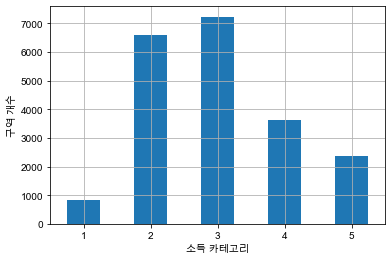

In [24]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

사이킷런이 제공하는 분할기(spliter) 클래스

분할기(spliter): 데이터셋을 훈련 세트와 테스트 세트로 분할하는 다양한 전략을 구현한 것
- split() 메서드: 훈련과 테스트 분할에 대한 반복자를 반환 (인덱스를 반환)

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit


splitter=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits=[]
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n=housing.iloc[train_index]
    strat_test_set_n=housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [26]:
strat_train_set, strat_test_set=strat_splits[0]

In [27]:
#하나의 분할이 필요한 경우 간단하게 사용
strat_train_set, strat_test_set=train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [28]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [29]:
#사용하지 않는 특성을 삭제하고 데이터를 원래 상태로 복구
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1, inplace=True)

In [30]:
housing=strat_train_set.copy()

In [31]:
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

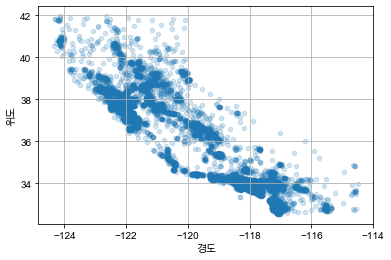

In [32]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True, alpha=0.2)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

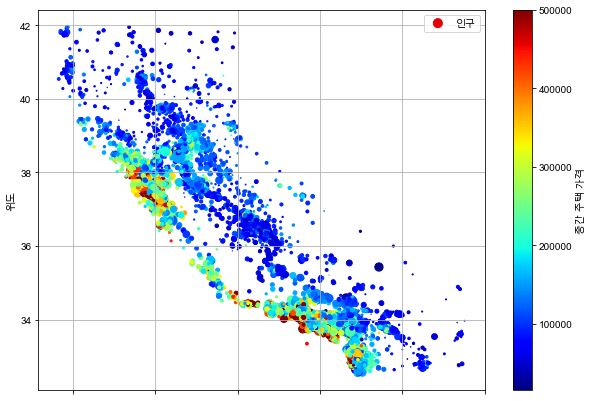

In [33]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True,
            s=housing["population"]/100,label="인구",
            c="median_house_value",cmap="jet",colorbar=True,
            legend=True, figsize=(10,7))
cax=plt.gcf().get_axes()[1]
cax.set_ylabel("중간 주택 가격")
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

In [34]:
corr_matrix=housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

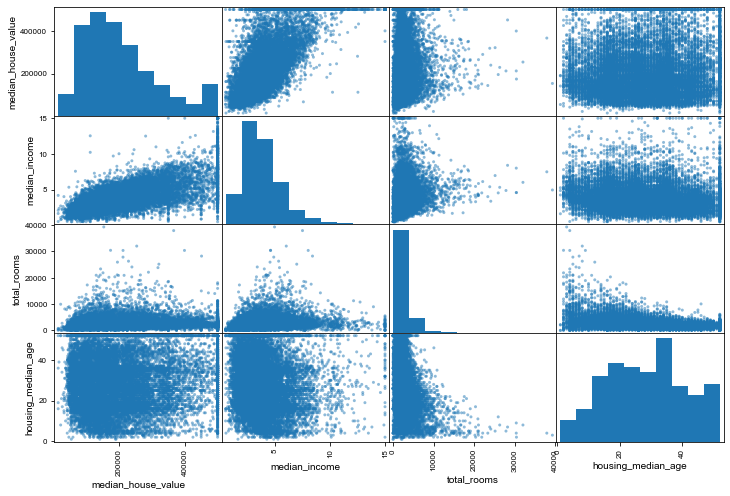

In [35]:
from pandas.plotting import scatter_matrix

attributes=["median_house_value","median_income","total_rooms",
           "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

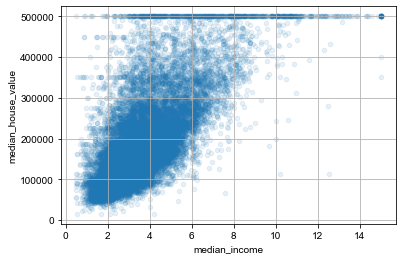

In [36]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",
            alpha=0.1,grid=True)
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.show()

In [37]:
housing["rooms_per_house"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_house"]=housing["population"]/housing["households"]

In [38]:
corr_matrix=housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

In [39]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [40]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [205]:
#해당 구역 제거
# housing.dropna(subset=["total_bedrooms"],inplace=True)

#전체 특성 삭제
# housing.drop("total_bedrooms",axis=1,inplace=True)

#대체
# median=housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median,inplace=True)

In [41]:
from sklearn.impute import SimpleImputer

imputer=SimpleImputer(strategy="median")
housing_num=housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [44]:
X=imputer.transform(housing_num)

In [45]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns,
                       index=housing_num.index)

In [46]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


텍스트 특성 다루기

In [47]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [48]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)

In [49]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [50]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [51]:
#One-hot Encoding
from sklearn.preprocessing import OneHotEncoder

cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)

In [52]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [53]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [55]:
df_test=pd.DataFrame({"ocean_proximity":["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [56]:
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

- get_dummies()는 범주형 특성을 원-핫 표현으로 바꿔서 카테고리마다 하나의 이진 특성을 만들지만 알 수 없는 카테고리를 감지하지 못 함
- OneHotEncoder는 알 수 없는 카테고리를 감지하고 예외를 발생시킬 수 있음

In [57]:
df_test_unknown=pd.DataFrame({"ocean_proximity":["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [58]:
cat_encoder.handle_unknown="ignore"
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [59]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [60]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [61]:
df_output=pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                      columns=cat_encoder.get_feature_names_out(),
                      index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


특성 스케일링 중 min-max 스케일링을 사용해 -1부터 1 사이의 범위로 정규화 
(신경망은 평균이 0인 데이터에서 잘 작동하므로 -1부터 1의 범위를 사용

In [62]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler=MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled=min_max_scaler.fit_transform(housing_num)

특성 스케일링 중 표준화를 사용해 스케일링

In [63]:
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()
housing_num_std_scaled=std_scaler.fit_transform(housing_num)

특성 스케일링 전 멀티모달 분포 문제를 해결하기 위해 RBF를 이용해 유사도 특성을 추가

In [64]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35=rbf_kernel(housing[["housing_median_age"]],[[35]],gamma=0.1)

레이블을 표준화를 사용해 스케일링하고 스케일링된 레이블로 모델을 훈련, 데이터 예측
변환기의 inverse_transform()을 사용해 원본 스케일로 되돌림

In [65]:
from sklearn.linear_model import LinearRegression

target_scaler=StandardScaler()
scaled_labels=target_scaler.fit_transform(housing_labels.to_frame())
model=LinearRegression()
model.fit(housing[["median_income"]],scaled_labels)
some_new_data=housing[["median_income"]].iloc[:5] #assume new data
scaled_predictions=model.predict(some_new_data)
predictions=target_scaler.inverse_transform(scaled_predictions)

변환기를 자동으로 작동하는 방법

In [66]:
from sklearn.compose import TransformedTargetRegressor

model=TransformedTargetRegressor(LinearRegression(),
                                transformer=StandardScaler())
model.fit(housing[["median_income"]],housing_labels)
predictions=model.predict(some_new_data)

특성 분포의 양수 꼬리가 두꺼울 경우에 적용하는 로그값으로 바꾸는 사용자 정의 변환기

In [67]:
from sklearn.preprocessing import FunctionTransformer

log_transformer=FunctionTransformer(np.log, inverse_func=np.exp)
log_pop=log_transformer.transform(housing[["population"]])

사용자 정의 변환기로 RBF 유사도 계산 변환기 만들기

In [68]:
rbf_transformer=FunctionTransformer(rbf_kernel, 
                                    kw_args=dict(Y=[[35.]],gamma=0.1))
age_simil_35=rbf_transformer.transform(housing[["housing_median_age"]])

각 구역과 샌프란시스코 사이의 지리적 유사도를 측정하는 특성을 추가

In [69]:
sf_coords=37.7749, -122.41
sf_transformer=FunctionTransformer(rbf_kernel,
                                  kw_args=dict(Y=[sf_coords],gamma=0.1))
sf_simil=sf_transformer.transform(housing[["latitude","longitude"]])

첫 번째 입력 특성과 두 번째 특성 사이의 비율을 계산하는 FunctionTransformer

In [70]:
ratio_transformer=FunctionTransformer(lambda X:X[:,[0]]/X[:,[1]])
ratio_transformer.transform(np.array([[1.,2.],[3.,4.]]))

array([[0.5 ],
       [0.75]])

fit() 메서드에서 특정 파라미터를 학습하고 나중에 transform() 메서드에서 이를 사용하기 위해 훈련 가능한 변환기가 필요할 경우 

**사용자 정의 클래스를 작성** 

TransformerMixin: fit_Transform을 자동으로 생성
BaseEstimator: 하이퍼파라미터 튜닝에 필요한 두 메서드(get_params()와 set_params())를 생성

In [71]:
#StandardScaler와 비슷하게 작동하는 사용자 정의 변환기
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self,with_mean=True): 
        self.with_mean=with_mean
        
    def fit(self,X,y=None):
        X=check_array(X)
        self.mean_=X.mean(axis=0)
        self.scale_=X.std(axis=0)
        self.n_features_in_=X.shape[1]
        return self
    
    def transform(self,X):
        check_is_fitted(self) 
        X=check_array(X)
        assert self.n_features_in_==X.shape[1]
        if self.with_mean:
            X=X-self.mean_
        return X/self.scale_

하나의 사용자 변환기가 구현 안에서 다른 추정기를 사용하는 경우

In [72]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10,gamma=1.0, random_state=None):
        self.n_clusters=n_clusters
        self.gamma=gamma
        self.random_state=random_state
        
    def fit(self,X,y=None, sample_weight=None):
        self.kmeans_=KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X,sample_weight=sample_weight)
        return self
    
    def transform(self,X):
        return rbf_kernel(X,self.kmeans_.cluster_centers_,gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters) ]

K-means 알고리즘은 클러스터를 찾기 위해 무작위성에 의존하므로 결과를 동일하게 재현하기 위해선 random_state 매개변수를 지정

In [73]:
cluster_simil=ClusterSimilarity(n_clusters=10,gamma=1.,random_state=42)
similarities=cluster_simil.fit_transform(housing[["latitude","longitude"]],
                                         sample_weight=housing_labels)

In [74]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

수치 특성에서 누락된 값을 대체하고 스케일을 조정하는 간단한 파이프라인

In [75]:
from sklearn.pipeline import Pipeline

num_pipeline=Pipeline([
    ("impute",SimpleImputer(strategy="meidan")),
    ("standardize",StandardScaler())
])

모든 사이킷런 추정기 보기

In [76]:
import sklearn
sklearn.set_config(display="diagram")

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='meidan')),
                ('standardize', StandardScaler())])

변환기의 이름을 짓고 싶지 않을 경우 사용

In [77]:
from sklearn.pipeline import make_pipeline

num_pipeline=make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

이 Pipeline의 fit_trandform() 메소드를 호출하고 출력

In [78]:
housing_num_prepared=num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

df_housing_num_prepared=pd.DataFrame(housing_num_prepared, 
                                    columns=num_pipeline.get_feature_names_out(),
                                    index=housing_num.index)

In [79]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


범주형 열과 수치형 열을 각각 다루지 않고 하나의 변환기로 각 열마다 적절한 변환을 적용하여 처리하기 위한 방법

In [80]:
from sklearn.compose import ColumnTransformer

num_attribs=["longitude","latitude","housing_median_age","total_rooms",
            "total_bedrooms","population","households","median_income"]
cat_attribs=["ocean_proximity"]

cat_pipeline=make_pipeline(SimpleImputer(strategy="most_frequent"),
                           OneHotEncoder(handle_unknown="ignore"))

preprocessing=ColumnTransformer([
    ("num",num_pipeline, num_attribs),
    ("cat",cat_pipeline, cat_attribs),
])

In [81]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing=make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [82]:
housing_prepared=preprocessing.fit_transform(housing)

지금까지의 변환을 모두 수행할 단일 파이프라인

In [83]:
def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] #get_feature_names_out에 사용

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,feature_names_out=ratio_name),
        StandardScaler())

log_pipeline=make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log,feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil=ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline=make_pipeline(SimpleImputer(strategy="median"),
                                  StandardScaler())

preprocessing=ColumnTransformer([
        ("bedrooms",ratio_pipeline(),["total_bedrooms","total_rooms"]),
        ("rooms_per_house",ratio_pipeline(),["total_rooms","households"]),
        ("people_per_house",ratio_pipeline(),["population","households"]),
        ("log",log_pipeline,["total_bedrooms","total_rooms","population",
                            "households","median_income"]),
        ("geo",cluster_simil, ["latitude","longitude"]),
        ("cat",cat_pipeline,make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) #남은 특성: house_median_age

In [84]:
housing_prepared=preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [85]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

## 훈련 세트에서 훈련하고 평가하기

1. 선형 회귀 모델 훈련

In [86]:
from sklearn.linear_model import LinearRegression

lin_reg=make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing,housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fb...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbdfa87efd0>)])),
                ('linearregression', LinearRegression())])

만들어진 선형 회귀 모델을 훈련 세트에 적용하고 다섯 개 예측과 레이블을 비교

In [87]:
housing_predictions=lin_reg.predict(housing)
housing_predictions[:5].round(-2) #-2: 십의 자리에서 반올림

array([246000., 372700., 135700.,  91400., 330900.])

In [88]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

RMSE를 사용하여 성능 측정하기

In [89]:
from sklearn.metrics import mean_squared_error

lin_rmse=mean_squared_error(housing_labels, housing_predictions,
                           squared=False)
lin_rmse

/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68972.88910758574

In [90]:
from sklearn.metrics import root_mean_squared_error

lin_rmse=root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758574

2. 결정 트리 모델 훈련

In [91]:
from sklearn.tree import DecisionTreeRegressor

tree_reg=make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing,housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fb...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbdfa87efd0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [92]:
housing_predictions=tree_reg.predict(housing)
# tree_rmse=mean_squared_error(housing_labels, housing_predictions, 
#                             squared=False)
tree_rmse=root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

In [93]:
from sklearn.model_selection import cross_val_score

tree_rmses=-cross_val_score(tree_reg, housing, housing_labels,
                           scoring="neg_root_mean_squared_error",cv=10)

pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.360949
std       1460.198570
min      64289.376198
25%      66776.146282
50%      67086.216281
75%      68140.275029
max      68659.294290
dtype: float64

3. RandomForestRegressor 모델

In [95]:
from sklearn.ensemble import RandomForestRegressor

forest_reg=make_pipeline(preprocessing,
                        RandomForestRegressor(random_state=42))
forest_rmses=-cross_val_score(forest_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

KeyboardInterrupt: 

## 미세튜닝

1. RandomForestRegressor를 GridSearchCV를 통해 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline=Pipeline([
    ("preprocessing",preprocessing),
    ("random_forest",RandomForestRegressor(random_state=42)),
])

param_grid=[
    {'preprocessing__geo__n_clusters':[5,8,10],
    'random_forest__max_features':[4,6,8]},
    {'preprocessing__geo__n_clusters':[10,15],
    'random_forest__max_features':[6,8,10]},
]
grid_search=GridSearchCV(full_pipeline, param_grid,cv=3,
                        scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
cv_res=pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False, inplace=True)

cv_res=cv_res.iloc[:,[4,5,7,8,9,10]]
cv_res.columns=["n_clusters", "max_features","split0","split1","split2","mean_test_rmse"]
cv_res.iloc[:,2:]=-cv_res.iloc[:,2:].round()
cv_res.head()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs={'preprocessing__geo__n_clusters':randint(low=3, high=50),
               'random_forest__max_features':randint(low=2, high=20)}

rnd_search=RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

***최상의 모델을 분석해 인사이트를 얻기 위해 RandomForestRegressor가 제공하는 특성의 상대적 중요도***

In [ ]:
final_model=rnd_search.best_estimator_ #전처리 포함

In [ ]:
feature_importances=final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()),
      reverse=True)

일반화 오차의 점 추정을 통해 시스템 평가 

In [ ]:
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set["median_house_value"].copy()

final_predictions=final_model.predict(X_test)

final_rmse=mean_squared_error(y_test, final_predictions,squared=False)
# final_rmse=root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

신뢰 구간을 계산하는 방법

In [ ]:
from scipy import stats
confidence=0.95
squared_errors=(final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

**론칭, 모니터링, 시스템 유지 보수**

In [ ]:
import joblib

joblib.dump(final_model, "my_valifornia_housing_model.pkl")

모델이 제품 환경으로 전달되고나서 로드해 사용

In [ ]:
import joblib 
[...]

def column ratio(X):[...]
def ratio_name(function_transformer, feature_names_in):[...]
class ClusterSimilarity(BaseEstimator, TransformerMixin):[...]

final_model_reloaded=joblib.load("my_california_housing_model.pkl")

new_data=[...]
predictions=final_model_reloaded.predict(new_data)

# 연습문제

### 1.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

param_grid=[
        {'svr__kernel':['linear'],'svr__C':[10., 30., 100., 300., 1000.,
                                           3000., 10000., 30000.0]},
        {'svr__kernel':['rbf'],'svr__C':[1.0, 3.0, 10., 30., 100., 300.,
                                        1000.0],
        'svr__gamma':[0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
    ]
svr_pipeline=Pipeline([("preprocessing",preprocessing),("svr",SVR())])
grid_search=GridSearchCV(svr_pipeline, param_grid,cv=3,
                        scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000],housing_labels.iloc[:5000])

NameError: name 'housing_labels' is not defined

In [ ]:
svr_grid_search_rmse=-grid_search.best_score_
svr_grid_search_rmse

In [ ]:
grid_search.best_params

### 2.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

param_distribs={
    'svr__kernel':['linear','rbf'],
    'svr__C': loguniform(20,200_000),
    'svr__gamma':expon(scale=1.0)
}

rnd_search=RandomizedSearchCV(svr_pipeline,
                             param_distribs,
                             cv=3,
                             scoring='neg_root_mean_squared_error',
                             random_state=42)
rnd_search.fit(X_train[:5000],y_train[:5000])

In [ ]:
svr_rnd_search_rmse=-rnd_search.best_score_
svr_rnd_search_rmse

In [ ]:
rnd_search.best_params_

In [ ]:
np.random.seed(42)

s=expon(scale=1).rvs(100_000)
((s>0.105)&(s<2.29)).sum()/100_000